In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as tk
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [32]:
fashion_mnist = tk.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [33]:
x_train = np.reshape(X_train_full, (60000, 28*28))

In [34]:
x_train = x_train/255

In [35]:
x_train.shape

(60000, 784)

In [36]:
pca = PCA(n_components=0.95)
x_reduced = pca.fit_transform(x_train)

Text(0, 0.5, 'Testing Accuracy')

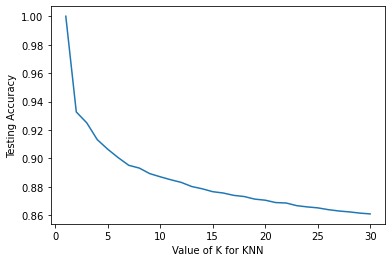

In [62]:
k_range = list(range(1, 31))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_reduced, y_train_full)
    pred = knn.predict(x_reduced)
    scores.append(metrics.accuracy_score(y_train_full, pred))
    
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [63]:
import seaborn as sns
plt.style.use('seaborn')

Text(0, 0.5, 'Testing Accuracy')

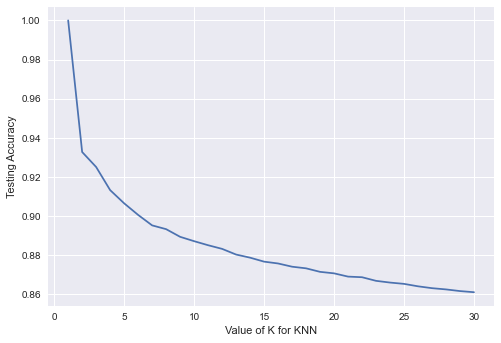

In [64]:
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

K=1 would be over-fitting and k=2 won't be good (if there are 2 neighbors and each one says something different, it would be hard to decide).
Thus, it seems that the best choice is k=3.
To be sure, we'll do another check, this time- using KFold and checking the mean score of each k and its std.

In [9]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

In [68]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

k_range = list(range(1, 31))
k_mean_scores = []
k_std_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_reduced, y_train_full, cv=kf, scoring='accuracy')
    k_mean_scores.append(scores.mean())
    k_std_scores.append(scores.std())

d = {'k_mean': k_mean_scores, 'k_std': k_std_scores}
Ks = pd.DataFrame(data = d, index=k_range)

In [69]:
Ks['k_mean'].sort_values(ascending=False).head(10)

6     0.866733
8     0.865183
4     0.865167
5     0.863983
7     0.863750
9     0.863650
10    0.863383
12    0.862267
11    0.862117
3     0.861633
Name: k_mean, dtype: float64

In [73]:
Ks['k_std'].sort_values(ascending=True)

17    0.003375
22    0.003420
14    0.003441
16    0.003443
18    0.003450
23    0.003553
21    0.003593
19    0.003613
24    0.003618
20    0.003631
27    0.003722
6     0.003763
11    0.003830
25    0.003863
26    0.003897
29    0.003901
30    0.003926
28    0.003954
15    0.003982
12    0.004021
8     0.004113
3     0.004155
13    0.004224
2     0.004372
7     0.004402
9     0.004675
5     0.004719
10    0.004799
1     0.004996
4     0.005290
Name: k_std, dtype: float64

we'll see that we can't be sure which k is the best to take, so we'll try to decide by doing Grid search

In [11]:
knn=KNeighborsClassifier()
k_range = list(range(3,31,2))
print(k_range)
weight_options = ['uniform', 'distance']
metrics_options = ['euclidean', 'manhattan']
param_grid = dict(n_neighbors=k_range, weights=weight_options, metric=metrics_options)
grid=GridSearchCV(knn, param_grid, cv=kf, scoring='accuracy')
print("getting to fit")
grid.fit(x_reduced, y_train_full)
print(grid.best_score_)
print(grid.best_params_)

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
getting to fit
0.8693166666666666
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


As we can see from the GridSearch, the best k to choose is k=5

In [12]:
our_best_knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan', weights='distance')

In [15]:
random_for = RandomForestClassifier()
randomfor_score = cross_val_score(random_for, x_reduced, y_train_full, cv=kf, scoring='accuracy').mean()
print(randomfor_score)

0.8663333333333332


In [16]:
from sklearn.naive_bayes import GaussianNB
naive_bay = GaussianNB()
bayes_score = cross_val_score(naive_bay, x_reduced, y_train_full, cv=kf, scoring='accuracy').mean()
print(bayes_score)

0.7488666666666667


In [20]:
from sklearn.linear_model import LogisticRegression
logis_reg = LogisticRegression(max_iter=1000, multi_class='multinomial')
reg_score = cross_val_score(logis_reg, x_reduced, y_train_full, cv=kf, scoring='accuracy').mean()
print(reg_score)

C:\Users\shira\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\shira\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.8578833333333332


C:\Users\shira\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We can see that the KNN model gives us the best results. Thus, we'll choose it to be our final model.

In [37]:
def get_data_ready(data):
    re_data = np.reshape(data, (len(data), 28*28))
    re_data = re_data/255
    final_data = pca.transform(re_data)
    return final_data

In [38]:
test = get_data_ready(X_test)

In [40]:
our_best_knn.fit(x_reduced, y_train_full)
final_predict = our_best_knn.predict(test)
print('Final accuracy score of model is: ', accuracy_score(y_test,final_predict))

Final accuracy score of model is:  0.8685
